# Univariate Time Series Forecasting with the LSTM Network in Python

Dataset: Shampoo Sales dataset
1. How to develop a baseline of performance for a forecast problem.
2. How to design a robust test harness for one-step time series forecasting.
3. How to prepare data, develop, and evaluate an LSTM recurrent neural network for time series forecasting.

#### Steps to follow:
1. Load the dataset from CSV file.
2. Transform the dataset to make it suitable for the LSTM model, including:
    - Transforming the data to a supervised learning problem.
    - Transforming the data to be stationary.
    - Transforming the data so that it has the scale -1 to 1.
3. Fitting a stateful LSTM network model to the training data.
4. Evaluating the static LSTM model on the test data.
5. Report the performance of the forecasts.

#### Source: https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/

#### Import Packages

In [15]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy

<ipython-input-15-f939ec2835ff>:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


#### Shampoo Sales Dataset

In [16]:
# load dataset
series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)

#### Transform Time Series to Stationary

In [46]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

In [48]:
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)
# We can also achieve this automatically using the diff() function in pandas.
#diff_values = DataFrame(raw_values).diff() #or
#diff_values = DataFrame(raw_values).diff(periods=1) 

#### Transform Time Series to Supervised Learning
The pushed-down series will have a new position at the top with no value. A NaN (not a number) value will be used in this position. We will replace these NaN values with 0 values, which the LSTM model will have to learn as “the start of the series” or “I have no data here,” as a month with zero sales on this dataset has not been observed.

In [49]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    # shift() function in Pandas push all values in a series down by a specified number places.
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

In [51]:
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

In [22]:
# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]

#### Transform Time Series to Scale
Like other neural networks, LSTMs expect data to be within the scale of the activation function used by the network.
The default activation function for LSTMs is the hyperbolic tangent (tanh), which outputs values between -1 and 1. This is the preferred range for the time series data.

In [23]:
# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

In [24]:
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

#### LSTM Model Development
The LSTM layer expects input to be in a matrix with the dimensions: [samples, time steps, features].
In Keras, this is referred to as stateful, and involves setting the “stateful” argument to “True” when defining an LSTM layer.

- _Samples_: These are independent observations from the domain, typically rows of data.
- _Time steps_: These are separate time steps of a given variable for a given observation.
- _Features_: These are separate measures observed at the time of observation.

__batch_size__: The batch size is often much smaller than the total number of samples. <br>
__epochs__: number of epochs, defines how quickly the network learns the data <br>
__neurons__:number of neurons, also called the number of memory units or blocks. This is a reasonably simple problem and a number between 1 and 5 should be sufficient.

__fit to the training data__
Disable the shuffling of samples by setting “shuffle” to “False“.
Also by default, the network reports a lot of debug information about the learning progress and skill of the model at the end of each epoch. We can disable this by setting the “verbose” argument to the level of “0“.

The batch_size must be set to 1. This is because it must be a factor of the size of the training and test datasets
The predict() function on the model is also constrained by the batch size; there it must be set to 1 because we are interested in making one-step forecasts on the test data.

In [53]:
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential() #Using the Sequential Keras API to define the network
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1)) #The network requires a single neuron in the output layer with a linear activation to predict
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

In [54]:
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 3000, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

array([[-0.8336627 ],
       [ 0.05089468],
       [-0.5649369 ],
       [ 0.08005798],
       [-0.32098764],
       [ 0.09252283],
       [-0.6001519 ],
       [-0.24253148],
       [-0.49279484],
       [ 0.5172821 ],
       [-1.0171685 ],
       [-0.03686492],
       [-0.12737441],
       [ 0.11391208],
       [-0.01442881],
       [-0.33614257],
       [ 0.50337213],
       [-0.33962288],
       [ 0.27104834],
       [-0.11694503],
       [ 0.36330056],
       [-0.74638563],
       [ 0.40009654]], dtype=float32)

#### LSTM Forecast

In [55]:
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

In [56]:
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [57]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [58]:
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions.append(yhat)
    expected = raw_values[len(train) + i + 1]
    print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

Month=1, Predicted=429.740474, Expected=339.700000
Month=2, Predicted=428.437984, Expected=440.400000
Month=3, Predicted=485.034554, Expected=315.900000
Month=4, Predicted=489.048483, Expected=439.300000
Month=5, Predicted=499.753018, Expected=401.300000
Month=6, Predicted=529.332971, Expected=437.400000
Month=7, Predicted=482.960403, Expected=575.500000
Month=8, Predicted=620.931222, Expected=407.600000
Month=9, Predicted=393.274542, Expected=682.000000
Month=10, Predicted=630.242030, Expected=475.300000
Month=11, Predicted=469.071096, Expected=581.300000
Month=12, Predicted=580.145472, Expected=646.900000


Test RMSE: 140.229


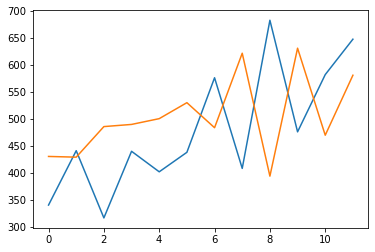

In [59]:
# report performance
rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_values[-12:])
pyplot.plot(predictions)
pyplot.show()

### Develop a Robust Result

A difficulty with neural networks is that they give different results with different starting conditions.

One approach might be to fix the random number seed used by Keras to ensure the results are reproducible. Another approach would be to control for the random initial conditions using a different experimental setup.

We can repeat the experiment from the previous section multiple times, then take the average RMSE as an indication of how well the configuration would be expected to perform on unseen data on average.

This is often called multiple repeats or multiple restarts.

In [ ]:
# repeat experiment
repeats = 30
error_scores = list()
for r in range(repeats):
    # fit the model
    lstm_model = fit_lstm(train_scaled, 1, 3000, 4)
    # forecast the entire training dataset to build up state for forecasting
    train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
    lstm_model.predict(train_reshaped, batch_size=1)
    # walk-forward validation on the test data
    predictions = list()
    for i in range(len(test_scaled)):
        # make one-step forecast
        X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
        yhat = forecast_lstm(lstm_model, 1, X)
        # invert scaling
        yhat = invert_scale(scaler, X, yhat)
        # invert differencing
        yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
        # store forecast
        predictions.append(yhat)
    # report performance
    rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
    print('%d) Test RMSE: %.3f' % (r+1, rmse))
    error_scores.append(rmse)

1) Test RMSE: 143.416
2) Test RMSE: 122.313
3) Test RMSE: 114.848
4) Test RMSE: 124.314
5) Test RMSE: 172.665
6) Test RMSE: 169.976
7) Test RMSE: 119.422
8) Test RMSE: 114.129
9) Test RMSE: 86.755
10) Test RMSE: 136.787


In [ ]:
# summarize results
results = DataFrame()
results['rmse'] = error_scores
print(results.describe())
results.boxplot()
pyplot.show()